# Classification d'image vue de face de veaux avec Unet

## Import des dependances

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
import torch
import torch.nn as nn
import torchvision.models.segmentation as segmentation
from torchvision import models
from torchvision.transforms import v2
from torchvision.io import read_image
import numpy as np
import cv2
import os
import sys
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from tqdm import tqdm
import random
from PIL import Image as PilImage
from omnixai.data.image import Image
from omnixai.explainers.vision import LimeImage, VisionExplainer
from omnixai.preprocessing.image import Resize
from torchsampler import ImbalancedDatasetSampler
from IPython.display import clear_output

# Local dep
project_dir = '/data/konrad/'
sys.path.insert(0, project_dir)

from helpers.helpers import get_indices, load_face_data, load_local_model
from helpers.datasets import CalfFaceDataset
from helpers.interp import GradCam, generate_cam, display_predicted_cam
from helpers.trainers import train_model, validate_model, plot_metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-06-20 09:39:03.438198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 09:39:04.089165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import de la data

Le fichier [face_eda](datasets/face_eda.ipynb) presente une etude de la donnee en generale. 

In [2]:
DATA_FILE = '/data/konrad/datasets/CompleteDatasetNormalFace/Face_annotations.csv'
IMAGE_DIR = "/data/konrad/datasets/CompleteDatasetNormalFace"

df, labels, label2id, id2label = load_face_data(DATA_FILE, IMAGE_DIR)

## Classes et utilitaires

In [3]:
class Classifier(nn.Module):
    def __init__(self, num_classes, name, from_pretrained = True):
        super(Classifier, self).__init__()
        self.name = name
        
        # self.unet = segmentation.deeplabv3_resnet50(pretrained=from_pretrained)  # Load the U-Net backbone
        self.unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=from_pretrained)

        # Remove the last segmentation layer
        self.unet.conv = nn.Identity()

        self.conv_head = nn.Conv2d(32, num_classes, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
            nn.Flatten(),
        )

    def forward(self, x):
        features = self.unet(x)
        features = self.conv_head(features)
        output = self.classifier_head(features)
        return output

## Entrainement du modele

### Dataset setup

In [15]:
train_indices, test_indices, valid_indices = get_indices(len(df))
IMAGE_SIZE = 512

train_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    # v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = CalfFaceDataset(df.iloc[train_indices, :].reset_index(drop=True), IMAGE_DIR, transform=train_transform)

test_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = CalfFaceDataset(df.iloc[test_indices, :].reset_index(drop=True), IMAGE_DIR, transform=test_transform)
valid_dataset = CalfFaceDataset(df.iloc[valid_indices, :].reset_index(drop=True), IMAGE_DIR, transform=test_transform)

# Data loaders
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_dataset))
valid_loader = DataLoader(valid_dataset, batch_size=batch_size * 2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)

# dl = valid_loader.dataset.data_frame
# class_counts = dl['label'].value_counts()

# # Plot the distribution
# plt.figure(figsize=(8, 6))
# class_counts.plot(kind='bar')
# plt.title('Distribution of Classes in Validation set')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

### Entrainement et validation

In [16]:
model_name = "unet"
model = Classifier(num_classes=len(labels), name=model_name, from_pretrained=True)  # Adjust num_classes according to your dataset
model.to(device)

# Loss and optimizer
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

epochs = 10
patience = 3

train_losses, train_accuracies, train_recalls, train_f1_scores, valid_losses, valid_accuracies, valid_recalls, valid_f1_scores = train_model(model, train_loader, test_loader, scheduler, patience, optimizer, num_epochs = epochs)
clear_output()

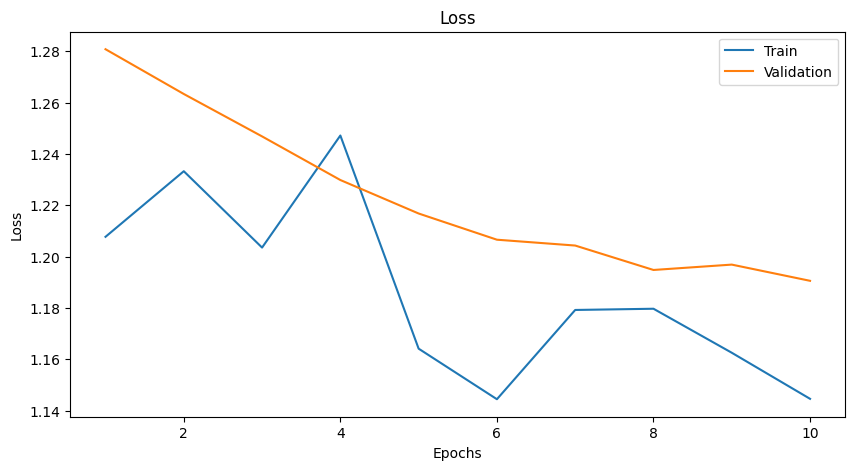

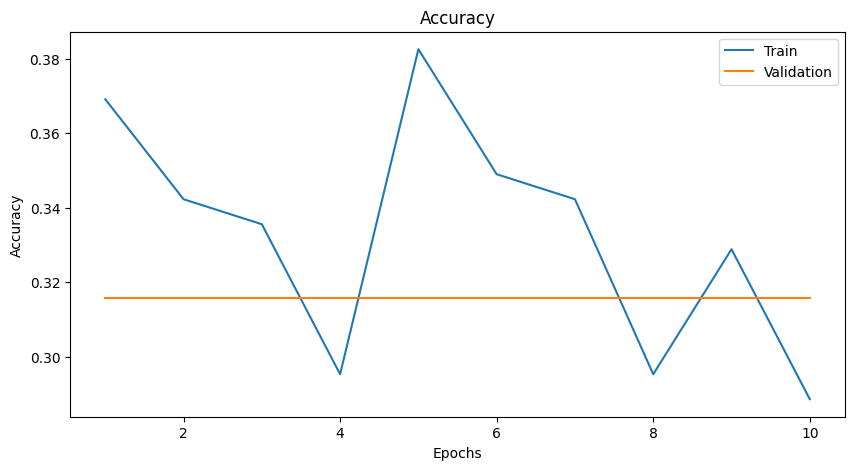

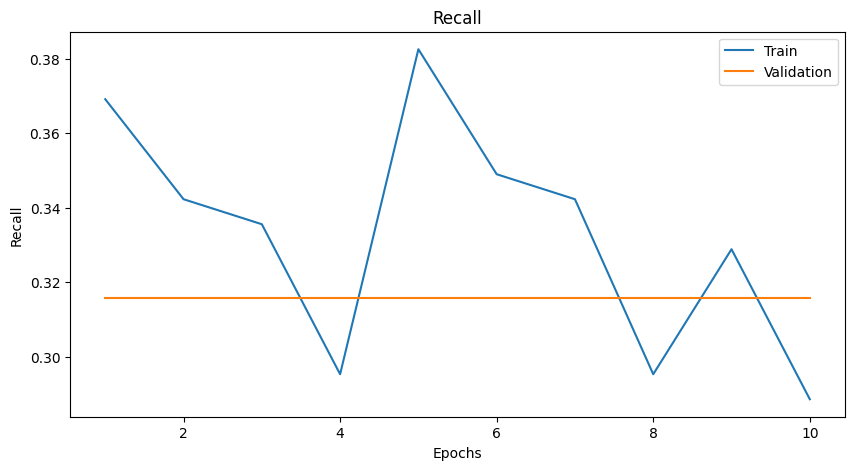

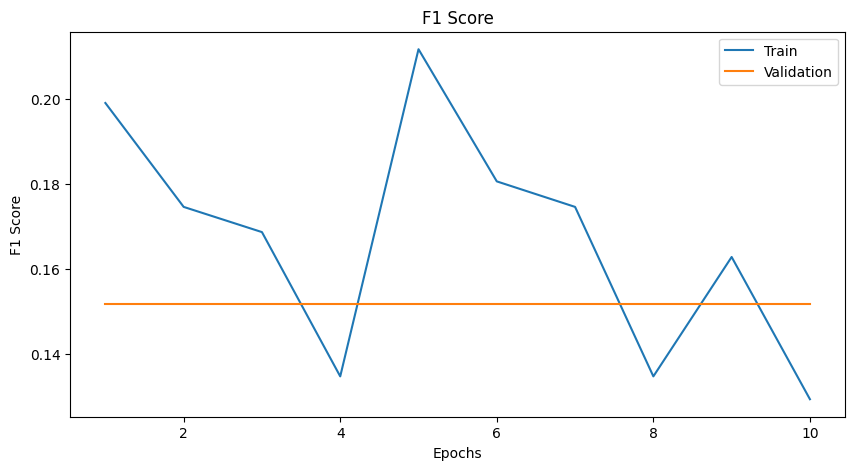

In [17]:
plot_metrics(train_losses, train_accuracies, train_recalls, train_f1_scores,  valid_losses, valid_accuracies, valid_recalls, valid_f1_scores)

In [18]:
validate_model(model, valid_loader, label2id.keys())

Test Accuracy: 0.4211, Micro Recall: 0.4211, Micro F1 Score: 0.4211
Class: Diarrhea, Precision: 0.4211, Recall: 1.0000, F1 Score: 0.5926
Class: Pneumonia, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Healthy, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


/data/konrad/jupiter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/data/konrad/jupiter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/data/konrad/jupiter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## Interpretation with Lime

In [7]:
# model = Classifier(num_classes=len(labels), name="inceptionv3", from_pretrained=False)  # Adjust num_classes according to your dataset
# load_local_model(model)
# model = model.to(device)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/konrad/jupiter_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/data/konrad/jupiter_env/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [19]:
test_df = valid_loader.dataset.data_frame.copy(deep=True)
test_df.reset_index(drop=True, inplace=True)
test_images = [Resize((256, 256)).transform(Image(PilImage.open(IMAGE_DIR + '/' + p["path"]).convert('RGB'))).to_numpy() for p in test_df.to_dict('records')]
img = Image( data=np.concatenate(test_images), batched=True)

# The preprocessing function
transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims]).to(device)
postprocess = lambda logits: torch.nn.functional.softmax(logits, dim=1)

target_head = model.conv_head
target_layer = model.conv_head
explainer = VisionExplainer(
    explainers=[
        "gradcam",
        "lime", 
        # "ig",
        # "ce",
        # "scorecam",
        # "smoothgrad", 
        "guidedbp", 
        "layercam"
    ],
    mode="classification",
    model=model,
    preprocess=preprocess,
    postprocess=postprocess,
    params={
        "gradcam": {"target_layer": target_head},
        # "ce": {"binary_search_steps": 2, "num_iterations": 100},
        # "scorecam": {"target_layer": target_head},
        "layercam": {"target_layer": target_layer},
    }
)

# Generate explanations
local_explanations = explainer.explain(img)
clear_output()

In [ ]:
df_per_class = {l:test_df[test_df["label"] == l] for l in labels}
class_id = 0
l, f_df  = list(df_per_class.items())[class_id]
print(f"Class label: {l}:\n\t")

for row_id in f_df.index.values:

    print(f"Interpretation pour image {row_id}: \n")
    for name, explanations in local_explanations.items():
        print(f"{name}:")
        explanations.ipython_plot(row_id, class_names=labels)


print("-" * 40)

In [ ]:
df_per_class = {l:test_df[test_df["label"] == l] for l in labels}
class_id = 1
l, f_df  = list(df_per_class.items())[class_id]
print(f"Class label: {l}:\n\t")

for row_id in f_df.index.values:

    print(f"Interpretation pour image {row_id}: \n")
    for name, explanations in local_explanations.items():
        print(f"{name}:")
        explanations.ipython_plot(row_id, class_names=labels)


print("-" * 40)

In [ ]:
df_per_class = {l:test_df[test_df["label"] == l] for l in labels}
class_id = 2
l, f_df  = list(df_per_class.items())[class_id]
print(f"Class label: {l}:\n\t")

for row_id in f_df.index.values:

    print(f"Interpretation pour image {row_id}: \n")
    for name, explanations in local_explanations.items():
        print(f"{name}:")
        explanations.ipython_plot(row_id, class_names=labels)


print("-" * 40)